# Vamos a leer el cluster 2 y generar una predicción basado en los trabajos de Diana

vamos por paso
Vamos a ver si por memoria tengo que partir

En este caso no voy a generar las covariables que generó Daiana

Voy a probar que corra, si corre luego le agrego las variables y veo los cambios en Kaggle

Vamos a ver con CPU y llegado el caso pruebo con GPU




## Preparo todo

In [ ]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [ ]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend

#import itertools

import gc
from datetime import datetime

#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold # Use KFold for regression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import early_stopping
import matplotlib.pyplot as plt
import os




In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.1 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

## Levanto el dataset
vamos a hacer el promedio de los últimos 12 meses por producto

In [ ]:
# me traigo el archivo ya procesado con la duración completa
df_cluster_2 = pd.read_parquet(DATOS_DIR +'df_cluster2_full.parquet')
#df_cluster_3.head()
# productos a validar Son los que se van a estar vivos
productos_validar = pd.read_csv(DATOS_DIR +'product_id_apredecir201912.txt', sep='\t')
# me traigo el clasificador de clusters


In [ ]:
# me quedo con las filas de df_cluster_3 cuyo product_id esté en productos_validar
###################################################
##### OJO, en realidad debo dejar todo
##### dejo las otras series que ayuden
##### saco de todo el conjunto lo que necesito al final
#############################
#df_cluster_X = df_cluster_3[df_cluster_3['product_id'].isin(productos_validar['product_id'])]
df_cluster_X = df_cluster_2.copy()
df_cluster_X.shape

(629073, 332)

In [ ]:
## A partir de df_cluster_X quiero generar un df_historia que tenga indice, primera columna produc_cust_id segunda columna el mínimo valor distinto de cero para dicho product_cust_id
# Filtra las filas donde tn es distinto de cero
df_filtrado = df_cluster_X[df_cluster_X['tn'] != 0]

# Agrupa por product_cust_id y calcula el mínimo de tn (distinto de cero)
df_historia = (
    df_filtrado
    .groupby('product_cust_id', as_index=False)['tn']
    .min()
    .rename(columns={'tn': 'min'})
)

print(df_historia.head())

  product_cust_id     min
0     20001_10001  13.297
1     20001_10004  34.648
2     20001_10005   0.862
3     20001_10006   3.551
4     20001_10008  11.090


## comenzamos con LGBM

tomo las ideas y valores de DI

La estructura de Chat

Y cruzo los dedos


In [ ]:
# Ordenar por product_cus_id y mes
df_cluster_X = df_cluster_X.sort_values(['product_cust_id', 'date_mes']).copy()

# Crear columna tn desplazada 2 meses adelante (tn_{t+2})
df_cluster_X['tn_shifted'] = (
    df_cluster_X.groupby('product_cust_id')['tn']
    .shift(-2)
)

# Crear target = tn_{t+2} - tn_{t}
df_cluster_X['target_diff'] = df_cluster_X['tn_shifted'] - df_cluster_X['tn']

In [ ]:
# Crear columna 'pc_id' como producto de product_id * customer_id (int64)
df_cluster_X['pc_id'] = df_cluster_X['product_id'] * df_cluster_X['customer_id']

# Crear columna 'p_id' convirtiendo product_id a string
df_cluster_X['p_id'] = df_cluster_X['product_id'].astype(str)

# Crear columna 'c_id' convirtiendo customer_id a string
df_cluster_X['c_id'] = df_cluster_X['customer_id'].astype(str)

In [ ]:
# Filtrar filas donde target_diff existe (meses 1 a 34)
df_model = df_cluster_X[df_cluster_X['target_diff'].notnull()].copy()

In [ ]:
df_model.shape

(592735, 337)

In [ ]:
# me guardo copia del modelo, por las dudas
df_model_backup = df_model.copy()

In [ ]:
# ----- Paso 1: Definir columnas -----

# Variables categóricas (tipo object o category), excluyendo product_cus_id
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
if 'product_cust_id' in categorical_cols:
    categorical_cols.remove('product_cust_id')
if 'p_id' in categorical_cols:
    categorical_cols.remove('p_id')
if 'c_id' in categorical_cols:
    categorical_cols.remove('c_id')


# Variable objetivo e IDs a excluir de features
exclude_cols = ['target_diff', 'tn', 'tn_shifted', 'product_cust_id', 'date_mes']

# Variables numéricas (excluyendo categóricas y columnas a excluir)
num_cols = [
    c for c in df_model.columns
    if c not in categorical_cols + exclude_cols and np.issubdtype(df_model[c].dtype, np.number)
]

In [ ]:
scalers = {}

for col in num_cols:
    col_data = df_model[col]
    std = col_data.std()
    mean = col_data.mean()

    if std > 0:
        df_model[col] = col_data / std
        scalers[col] = ('std', std)
    elif mean > 0:
        df_model[col] = col_data / mean
        scalers[col] = ('mean', mean)
    else:
        # No se escala si std=0 y mean=0
        scalers[col] = ('none', None)

In [ ]:
## dejo por si hace falta luego escalar por serie: OJO menos valores más inestable. pero captura mejor los detalles
def normalize_group(df, cols):
    df_norm = df.copy()
    for col in cols:
        def scale_func(x):
            std = x.std()
            mean = x.mean()
            if std > 0:
                return x / std
            elif mean > 0:
                return x / mean
            else:
                return x
        df_norm[col] = df.groupby('product_cus_id')[col].transform(scale_func)
    return df_norm

#df_model_norm = normalize_group(df_model, num_cols)

In [ ]:
# ----- Paso 3: Label Encoding para categóricas -----

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    vals = df_model[col].astype(str).fillna('missing')
    df_model[col] = le.fit_transform(vals)
    le_dict[col] = le

In [ ]:
df_model.head()

,customer_id,product_id,date_mes,first_customer_date,last_customer_date,first_product_date,last_product_date,tn,dif_tn,dif_por,vida_prod,vida_customer,meses_on,meses_off,vida_restante,anio,mes,secuencia,trimestre,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,periodo,stock_final,dias_laborables_arg,cisne_negro,VtaGral,VtaGralCte,Bebidas,Almacen,Panaderia,Lacteos,Carnes,Verduleria_y_fruteria,Articulos_de_limpieza_y_perfumeria,Indumentaria_calzado_y_textiles_para_el_hogar,Electronicos_y_articulos_para_el_hogar,Otros,USD_of,USD_blue,Infl,Expect,product_cust_id,tn_sum_cus,tn_sum_cus_rolling_3m,tn_sum_cus_rolling_3m_min,tn_sum_cus_rolling_3m_max,tn_sum_cus_rolling_3m_std,tn_sum_cus_rolling_6m,tn_sum_cus_rolling_6m_min,tn_sum_cus_rolling_6m_max,tn_sum_cus_rolling_6m_std,tn_sum_cus_rolling_9m,tn_sum_cus_rolling_9m_min,tn_sum_cus_rolling_9m_max,tn_sum_cus_rolling_9m_std,tn_sum_cus_rolling_12m,tn_sum_cus_rolling_12m_min,tn_sum_cus_rolling_12m_max,tn_sum_cus_rolling_12m_std,tn_sum_cus_lag_3m,tn_sum_cus_lag_3m_min,tn_sum_cus_lag_3m_max,tn_sum_cus_lag_3m_std,tn_sum_cus_lag_6m,tn_sum_cus_lag_6m_min,tn_sum_cus_lag_6m_max,tn_sum_cus_lag_6m_std,tn_sum_cus_lag_9m,tn_sum_cus_lag_9m_min,tn_sum_cus_lag_9m_max,tn_sum_cus_lag_9m_std,tn_sum_cus_lag_12m,tn_sum_cus_lag_12m_min,tn_sum_cus_lag_12m_max,tn_sum_cus_lag_12m_std,delta_rolling_3m,delta_rolling_3m_min,delta_rolling_3m_max,delta_rolling_3m_std,delta_rolling_6m,delta_rolling_6m_min,delta_rolling_6m_max,delta_rolling_6m_std,delta_rolling_9m,delta_rolling_9m_min,delta_rolling_9m_max,delta_rolling_9m_std,delta_rolling_12m,delta_rolling_12m_min,delta_rolling_12m_max,delta_rolling_12m_std,delta_lag_3m,delta_lag_3m_min,delta_lag_3m_max,delta_lag_3m_std,delta_lag_6m,delta_lag_6m_min,delta_lag_6m_max,delta_lag_6m_std,delta_lag_9m,delta_lag_9m_min,delta_lag_9m_max,delta_lag_9m_std,delta_lag_12m,delta_lag_12m_min,delta_lag_12m_max,delta_lag_12m_std,tn_sum_cus_min,tn_sum_cus_max,tn_sum_cus_std,tn_sum_prod,tn_sum_prod_rolling_3m,tn_sum_prod_rolling_3m_min,tn_sum_prod_rolling_3m_max,tn_sum_prod_rolling_3m_std,tn_sum_prod_rolling_6m,tn_sum_prod_rolling_6m_min,tn_sum_prod_rolling_6m_max,tn_sum_prod_rolling_6m_std,tn_sum_prod_rolling_9m,tn_sum_prod_rolling_9m_min,tn_sum_prod_rolling_9m_max,tn_sum_prod_rolling_9m_std,tn_sum_prod_rolling_12m,tn_sum_prod_rolling_12m_min,tn_sum_prod_rolling_12m_max,tn_sum_prod_rolling_12m_std,tn_sum_prod_lag_3m,tn_sum_prod_lag_3m_min,tn_sum_prod_lag_3m_max,tn_sum_prod_lag_3m_std,tn_sum_prod_lag_6m,tn_sum_prod_lag_6m_min,tn_sum_prod_lag_6m_max,tn_sum_prod_lag_6m_std,tn_sum_prod_lag_9m,tn_sum_prod_lag_9m_min,tn_sum_prod_lag_9m_max,tn_sum_prod_lag_9m_std,tn_sum_prod_lag_12m,tn_sum_prod_lag_12m_min,tn_sum_prod_lag_12m_max,tn_sum_prod_lag_12m_std,delta_rolling_3m_prod,delta_rolling_3m_min_prod,delta_rolling_3m_max_prod,delta_rolling_3m_std_prod,delta_rolling_6m_prod,delta_rolling_6m_min_prod,delta_rolling_6m_max_prod,delta_rolling_6m_std_prod,delta_rolling_9m_prod,delta_rolling_9m_min_prod,delta_rolling_9m_max_prod,delta_rolling_9m_std_prod,delta_rolling_12m_prod,delta_rolling_12m_min_prod,delta_rolling_12m_max_prod,delta_rolling_12m_std_prod,delta_lag_3m_prod,delta_lag_3m_min_prod,delta_lag_3m_max_prod,delta_lag_3m_std_prod,delta_lag_6m_prod,delta_lag_6m_min_prod,delta_lag_6m_max_prod,delta_lag_6m_std_prod,delta_lag_9m_prod,delta_lag_9m_min_prod,delta_lag_9m_max_prod,delta_lag_9m_std_prod,delta_lag_12m_prod,delta_lag_12m_min_prod,delta_lag_12m_max_prod,delta_lag_12m_std_prod,tn_sum_prod_min,tn_sum_prod_max,tn_sum_prod_std,tn_lag1,tn_lag2,tn_lag3,tn_lag4,tn_lag5,tn_lag6,tn_lag7,tn_lag8,tn_lag9,tn_lag10,tn_lag11,tn_lag12,tn_mean_3m,tn_min_3m,tn_max_3m,tn_std_3m,tn_trend_3m,tn_meses_desde_max_3m,tn_mean_6m,tn_min_6m,tn_max_6m,tn_std_6m,tn_trend_6m,tn_meses_desde_max_6m,tn_mean_9m,tn_min_9m,tn_max_9m,tn_std_9m,tn_trend_9m,tn_meses_desde_max_9m,tn_mean_12m,tn_min_12m,tn_max_12m,tn_std_12m,tn_trend_12m,tn_meses_desde_max_12m,tn_cat1_cus_mes,tn_cat1_cat2_cus_mes,

In [ ]:
# ----- Paso 4: Prep X, y -----

X = df_model[num_cols + categorical_cols]
y = df_model['target_diff'].values


In [ ]:
# ----- Paso 5: Función objetivo Optuna con 5-Fold CV -----

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse', # dejo MSE por el problema
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=categorical_cols, free_raw_data=False)
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=1000,
            callbacks=[early_stopping(stopping_rounds=50)],
            #verbose_eval=False
        )
        preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmses.append(rmse)

    return np.mean(rmses)

In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Mejor RMSE promedio en CV: {study.best_value:.6f}')
print(f'Mejor parámetros: {study.best_params}')

[I 2025-07-20 05:14:59,957] A new study created in memory with name: no-name-c081fb02-1737-4dbe-8e25-7bfbd615d432
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipython-input-20-1238785233.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uni

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's l2: 15.0015
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's l2: 12.7799
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's l2: 12.0781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid_0's l2: 11.9277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's l2: 11.9055


[I 2025-07-20 05:17:35,293] Trial 0 finished with value: 3.5655022094389417 and parameters: {'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.07115024603736503, 'feature_fraction': 0.9644120556294603, 'bagging_fraction': 0.7985683105225051, 'bagging_freq': 7, 'min_data_in_leaf': 81, 'lambda_l1': 7.933931528623825e-05, 'lambda_l2': 8.834985384989349e-07}. Best is trial 0 with value: 3.5655022094389417.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[696]	valid_0's l2: 14.3178
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[724]	valid_0's l2: 12.1802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 11.4044
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.3077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[725]	valid_0's l2: 11.5856


[I 2025-07-20 05:24:40,652] Trial 1 finished with value: 3.4834796127349854 and parameters: {'num_leaves': 108, 'max_depth': 17, 'learning_rate': 0.023456375724879224, 'feature_fraction': 0.6393605223293479, 'bagging_fraction': 0.8053251505125544, 'bagging_freq': 1, 'min_data_in_leaf': 49, 'lambda_l1': 3.8708110940541336, 'lambda_l2': 0.0003494502686963745}. Best is trial 1 with value: 3.4834796127349854.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's l2: 15.1594
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's l2: 12.8655
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's l2: 12.0546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's l2: 12.2566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 12.3803


[I 2025-07-20 05:26:23,241] Trial 2 finished with value: 3.5943660396813746 and parameters: {'num_leaves': 154, 'max_depth': 15, 'learning_rate': 0.07205487831918257, 'feature_fraction': 0.6283870158918977, 'bagging_fraction': 0.601847891546849, 'bagging_freq': 6, 'min_data_in_leaf': 87, 'lambda_l1': 0.004785914665749832, 'lambda_l2': 0.4969118188194066}. Best is trial 1 with value: 3.4834796127349854.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's l2: 14.4241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[411]	valid_0's l2: 12.1501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[616]	valid_0's l2: 11.4118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 11.025
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.2624


[I 2025-07-20 05:31:52,797] Trial 3 finished with value: 3.467615864958635 and parameters: {'num_leaves': 95, 'max_depth': 16, 'learning_rate': 0.039136159218860274, 'feature_fraction': 0.5880524446003523, 'bagging_fraction': 0.9541160474228958, 'bagging_freq': 7, 'min_data_in_leaf': 43, 'lambda_l1': 8.952254465139587e-05, 'lambda_l2': 1.7926824808788396e-08}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's l2: 14.6395
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's l2: 12.7417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[707]	valid_0's l2: 11.7489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's l2: 11.8298
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[236]	valid_0's l2: 12.1614


[I 2025-07-20 05:36:21,194] Trial 4 finished with value: 3.5500295405635534 and parameters: {'num_leaves': 224, 'max_depth': 12, 'learning_rate': 0.03909614161345167, 'feature_fraction': 0.9557218645687511, 'bagging_fraction': 0.9274219907991346, 'bagging_freq': 5, 'min_data_in_leaf': 91, 'lambda_l1': 0.047617176902607965, 'lambda_l2': 2.499412393949113e-07}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[157]	valid_0's l2: 15.1449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's l2: 12.7717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	valid_0's l2: 12.0005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 12.1568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l2: 12.4917


[I 2025-07-20 05:38:17,046] Trial 5 finished with value: 3.5901166503953186 and parameters: {'num_leaves': 230, 'max_depth': 8, 'learning_rate': 0.04406474552541181, 'feature_fraction': 0.746205844492841, 'bagging_fraction': 0.6347769341449653, 'bagging_freq': 6, 'min_data_in_leaf': 83, 'lambda_l1': 0.056984915252639955, 'lambda_l2': 0.0006813580456376871}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[862]	valid_0's l2: 14.4915
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[966]	valid_0's l2: 12.3559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[842]	valid_0's l2: 11.5952
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[897]	valid_0's l2: 11.7493


[I 2025-07-20 05:45:27,715] Trial 6 finished with value: 3.5117454978914964 and parameters: {'num_leaves': 91, 'max_depth': 17, 'learning_rate': 0.014542358452887517, 'feature_fraction': 0.5519438243139172, 'bagging_fraction': 0.8641090292184425, 'bagging_freq': 7, 'min_data_in_leaf': 83, 'lambda_l1': 5.84830982726781e-07, 'lambda_l2': 0.039168809497187755}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 15.2502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's l2: 13.024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's l2: 12.4669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's l2: 12.277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[194]	valid_0's l2: 11.9819


[I 2025-07-20 05:46:54,094] Trial 7 finished with value: 3.6020452384942323 and parameters: {'num_leaves': 16, 'max_depth': 8, 'learning_rate': 0.15347667297482512, 'feature_fraction': 0.5679159024838492, 'bagging_fraction': 0.8608183088884146, 'bagging_freq': 1, 'min_data_in_leaf': 77, 'lambda_l1': 2.1393533428440543e-07, 'lambda_l2': 8.142435348184278e-07}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 14.8867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's l2: 12.7721
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 12.2088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's l2: 12.07
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's l2: 12.2188


[I 2025-07-20 05:49:11,137] Trial 8 finished with value: 3.5791958854281893 and parameters: {'num_leaves': 254, 'max_depth': 15, 'learning_rate': 0.1003850711268502, 'feature_fraction': 0.9819138163287203, 'bagging_fraction': 0.7398328608509954, 'bagging_freq': 1, 'min_data_in_leaf': 82, 'lambda_l1': 7.276923410153394e-06, 'lambda_l2': 1.761622855012914}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('featu

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[699]	valid_0's l2: 14.744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[501]	valid_0's l2: 12.643
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[967]	valid_0's l2: 11.7089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[946]	valid_0's l2: 11.9094
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's l2: 11.8241


[I 2025-07-20 05:58:34,752] Trial 9 finished with value: 3.54139163279226 and parameters: {'num_leaves': 191, 'max_depth': 14, 'learning_rate': 0.01812007974066989, 'feature_fraction': 0.9758256805147922, 'bagging_fraction': 0.8295850419347988, 'bagging_freq': 1, 'min_data_in_leaf': 100, 'lambda_l1': 3.983595368804703e-05, 'lambda_l2': 0.384010238095948}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('featu

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 14.1557
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 12.1144
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.6969
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.3618
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 11.3829


[I 2025-07-20 06:11:17,636] Trial 10 finished with value: 3.48152780220576 and parameters: {'num_leaves': 151, 'max_depth': 20, 'learning_rate': 0.010385389874013278, 'feature_fraction': 0.7875497772556461, 'bagging_fraction': 0.9963224240877941, 'bagging_freq': 3, 'min_data_in_leaf': 42, 'lambda_l1': 1.0851158817284281e-08, 'lambda_l2': 1.0424005713156418e-08}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's l2: 14.1421
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 12.1174
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.5685
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.3012
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.4261


[I 2025-07-20 06:24:58,884] Trial 11 finished with value: 3.4769667291599675 and parameters: {'num_leaves': 170, 'max_depth': 20, 'learning_rate': 0.01041370551857393, 'feature_fraction': 0.8107740974680583, 'bagging_fraction': 0.9990833535836303, 'bagging_freq': 3, 'min_data_in_leaf': 40, 'lambda_l1': 1.1497893590422839e-08, 'lambda_l2': 1.4073499512171359e-08}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[347]	valid_0's l2: 14.3879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[554]	valid_0's l2: 12.223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[711]	valid_0's l2: 11.5402
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's l2: 11.2341
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[534]	valid_0's l2: 11.5899


[I 2025-07-20 06:34:09,418] Trial 12 finished with value: 3.4884975640755562 and parameters: {'num_leaves': 182, 'max_depth': 20, 'learning_rate': 0.025865863502936095, 'feature_fraction': 0.7990145199723924, 'bagging_fraction': 0.9974659603945569, 'bagging_freq': 3, 'min_data_in_leaf': 61, 'lambda_l1': 1.7240709852458907e-08, 'lambda_l2': 1.5733861492522907e-08}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifo

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	valid_0's l2: 15.4341
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's l2: 12.8495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	valid_0's l2: 12.5081
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's l2: 12.2841
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[328]	valid_0's l2: 12.1371


[I 2025-07-20 06:35:54,572] Trial 13 finished with value: 3.607725880684651 and parameters: {'num_leaves': 68, 'max_depth': 3, 'learning_rate': 0.1930202241870601, 'feature_fraction': 0.7035656656223178, 'bagging_fraction': 0.9326804295129042, 'bagging_freq': 3, 'min_data_in_leaf': 57, 'lambda_l1': 0.0009016596176625973, 'lambda_l2': 1.5258352033521986e-05}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 14.1102
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 12.1189
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.6962
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.4136
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.3969


[I 2025-07-20 06:47:43,841] Trial 14 finished with value: 3.48237596496246 and parameters: {'num_leaves': 124, 'max_depth': 19, 'learning_rate': 0.010466812340024808, 'feature_fraction': 0.8747677122311971, 'bagging_fraction': 0.9351527767671857, 'bagging_freq': 4, 'min_data_in_leaf': 40, 'lambda_l1': 1.3375267931000672e-06, 'lambda_l2': 3.129323275263724e-05}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[885]	valid_0's l2: 14.3948
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 12.1529
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[938]	valid_0's l2: 11.85
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.376
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[963]	valid_0's l2: 11.4112


[I 2025-07-20 06:54:04,965] Trial 15 finished with value: 3.4946827005840406 and parameters: {'num_leaves': 25, 'max_depth': 17, 'learning_rate': 0.030185454295058162, 'feature_fraction': 0.8262241680207019, 'bagging_fraction': 0.953470268858737, 'bagging_freq': 4, 'min_data_in_leaf': 51, 'lambda_l1': 1.2556810858756622, 'lambda_l2': 1.3017508063891818e-07}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's l2: 14.7052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's l2: 12.5867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 12.1014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[400]	valid_0's l2: 11.8053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[415]	valid_0's l2: 11.9828


[I 2025-07-20 06:56:42,356] Trial 16 finished with value: 3.5517436452691604 and parameters: {'num_leaves': 178, 'max_depth': 12, 'learning_rate': 0.06408238873792603, 'feature_fraction': 0.7067529160137018, 'bagging_fraction': 0.7254003966478854, 'bagging_freq': 2, 'min_data_in_leaf': 68, 'lambda_l1': 0.000873795643581036, 'lambda_l2': 9.41521339737337e-06}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[823]	valid_0's l2: 14.348
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 12.1087
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's l2: 11.4324
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.2613
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.4141


[I 2025-07-20 07:02:50,180] Trial 17 finished with value: 3.4766142658522687 and parameters: {'num_leaves': 78, 'max_depth': 18, 'learning_rate': 0.01572174350981423, 'feature_fraction': 0.5150738318790247, 'bagging_fraction': 0.8906059337800556, 'bagging_freq': 5, 'min_data_in_leaf': 47, 'lambda_l1': 1.3312210609189691e-07, 'lambda_l2': 0.003842573507624985}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[839]	valid_0's l2: 14.3943
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[966]	valid_0's l2: 12.2059
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 11.4995
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 11.2906
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 11.4619


[I 2025-07-20 07:08:37,562] Trial 18 finished with value: 3.4848904319648697 and parameters: {'num_leaves': 69, 'max_depth': 14, 'learning_rate': 0.01744907701054475, 'feature_fraction': 0.5048035529685039, 'bagging_fraction': 0.8919906080615139, 'bagging_freq': 6, 'min_data_in_leaf': 48, 'lambda_l1': 7.777935924109298e-06, 'lambda_l2': 0.007439907712511335}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	valid_0's l2: 14.5885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid_0's l2: 12.2399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's l2: 11.5578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[735]	valid_0's l2: 11.2755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[936]	valid_0's l2: 11.4237


[I 2025-07-20 07:12:53,762] Trial 19 finished with value: 3.4911023809733654 and parameters: {'num_leaves': 98, 'max_depth': 18, 'learning_rate': 0.03333816286101977, 'feature_fraction': 0.5020053648205305, 'bagging_fraction': 0.8950861766811892, 'bagging_freq': 5, 'min_data_in_leaf': 64, 'lambda_l1': 1.3382347697093926e-07, 'lambda_l2': 0.007288119218681005}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's l2: 14.6329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid_0's l2: 12.443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's l2: 12.0052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[717]	valid_0's l2: 11.5443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[592]	valid_0's l2: 11.8409


[I 2025-07-20 07:15:48,714] Trial 20 finished with value: 3.5312725613777913 and parameters: {'num_leaves': 42, 'max_depth': 10, 'learning_rate': 0.05452225102313129, 'feature_fraction': 0.6191463634064266, 'bagging_fraction': 0.7572955141541361, 'bagging_freq': 5, 'min_data_in_leaf': 55, 'lambda_l1': 2.703314167494809e-06, 'lambda_l2': 0.0038825663646385603}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 14.298
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.9755
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.5564
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 11.3088
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.4947


[I 2025-07-20 07:24:27,076] Trial 21 finished with value: 3.47890868366797 and parameters: {'num_leaves': 131, 'max_depth': 18, 'learning_rate': 0.013607243104671188, 'feature_fraction': 0.5498173111196898, 'bagging_fraction': 0.9696601279256138, 'bagging_freq': 7, 'min_data_in_leaf': 44, 'lambda_l1': 5.981628517357183e-08, 'lambda_l2': 6.17993958381174e-08}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[483]	valid_0's l2: 14.1855
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 12.0155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[744]	valid_0's l2: 11.5942
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.2831
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 11.4473


[I 2025-07-20 07:35:16,693] Trial 22 finished with value: 3.476027994055751 and parameters: {'num_leaves': 151, 'max_depth': 20, 'learning_rate': 0.019620871493295496, 'feature_fraction': 0.884722233488287, 'bagging_fraction': 0.8975294749086572, 'bagging_freq': 2, 'min_data_in_leaf': 46, 'lambda_l1': 4.266038405365231e-08, 'lambda_l2': 6.528861174711125e-05}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[552]	valid_0's l2: 14.2297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[710]	valid_0's l2: 12.1324
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 11.5073
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 11.3532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[665]	valid_0's l2: 11.5989


[I 2025-07-20 07:44:11,690] Trial 23 finished with value: 3.4845581796294085 and parameters: {'num_leaves': 111, 'max_depth': 15, 'learning_rate': 0.021464066720716202, 'feature_fraction': 0.8964221047130204, 'bagging_fraction': 0.8970210395854482, 'bagging_freq': 2, 'min_data_in_leaf': 54, 'lambda_l1': 4.4138113506637605e-05, 'lambda_l2': 0.0001686482888564097}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[681]	valid_0's l2: 14.3255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[470]	valid_0's l2: 12.3797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[661]	valid_0's l2: 11.5028
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 11.0259
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 11.1599


[I 2025-07-20 07:49:41,424] Trial 24 finished with value: 3.471224445999026 and parameters: {'num_leaves': 83, 'max_depth': 18, 'learning_rate': 0.03133717465174055, 'feature_fraction': 0.5875071385539807, 'bagging_fraction': 0.8507755113061503, 'bagging_freq': 2, 'min_data_in_leaf': 46, 'lambda_l1': 4.6093448718347486e-07, 'lambda_l2': 0.0688904890515065}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's l2: 14.449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's l2: 12.4387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[601]	valid_0's l2: 11.5586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[680]	valid_0's l2: 11.4706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	valid_0's l2: 11.56


[I 2025-07-20 07:54:52,212] Trial 25 finished with value: 3.502930744443139 and parameters: {'num_leaves': 147, 'max_depth': 16, 'learning_rate': 0.033632857740325824, 'feature_fraction': 0.6693550822116927, 'bagging_fraction': 0.8505071838827634, 'bagging_freq': 2, 'min_data_in_leaf': 61, 'lambda_l1': 6.371992551192101e-07, 'lambda_l2': 6.52799497656303}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feat

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's l2: 15.1527
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[312]	valid_0's l2: 12.7787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[618]	valid_0's l2: 12.1471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[720]	valid_0's l2: 11.8163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[399]	valid_0's l2: 12.0988


[I 2025-07-20 07:57:09,262] Trial 26 finished with value: 3.573694597508909 and parameters: {'num_leaves': 48, 'max_depth': 4, 'learning_rate': 0.049939545272472886, 'feature_fraction': 0.5819328002915655, 'bagging_fraction': 0.7927018064614514, 'bagging_freq': 2, 'min_data_in_leaf': 45, 'lambda_l1': 7.210365887128789e-06, 'lambda_l2': 0.07029400631167816}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's l2: 14.6301
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[636]	valid_0's l2: 12.4767
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	valid_0's l2: 11.6876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[542]	valid_0's l2: 11.6273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid_0's l2: 11.8415


[I 2025-07-20 08:03:07,823] Trial 27 finished with value: 3.5253818391613314 and parameters: {'num_leaves': 118, 'max_depth': 19, 'learning_rate': 0.027789034375171988, 'feature_fraction': 0.8892604626822059, 'bagging_fraction': 0.6982144066250784, 'bagging_freq': 4, 'min_data_in_leaf': 53, 'lambda_l1': 0.0002044045681166806, 'lambda_l2': 1.958319538061704e-06}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's l2: 14.7511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[173]	valid_0's l2: 12.4994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's l2: 12.0072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[421]	valid_0's l2: 11.7096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 12.2195


[I 2025-07-20 08:05:39,727] Trial 28 finished with value: 3.5517726673703516 and parameters: {'num_leaves': 201, 'max_depth': 13, 'learning_rate': 0.08873823502077582, 'feature_fraction': 0.7324780200649057, 'bagging_fraction': 0.8273371392935132, 'bagging_freq': 2, 'min_data_in_leaf': 72, 'lambda_l1': 5.448316900122232e-08, 'lambda_l2': 8.641833725465591e-05}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[375]	valid_0's l2: 14.4448
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[465]	valid_0's l2: 12.2093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[764]	valid_0's l2: 11.4378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[784]	valid_0's l2: 11.1175
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's l2: 11.3619


[I 2025-07-20 08:11:22,920] Trial 29 finished with value: 3.476364041581418 and parameters: {'num_leaves': 89, 'max_depth': 16, 'learning_rate': 0.0383900189270467, 'feature_fraction': 0.6018198144050919, 'bagging_fraction': 0.9656968589213462, 'bagging_freq': 3, 'min_data_in_leaf': 58, 'lambda_l1': 0.005291354787623472, 'lambda_l2': 5.303306851080489e-06}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[784]	valid_0's l2: 14.4732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[804]	valid_0's l2: 12.3518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[710]	valid_0's l2: 11.775
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's l2: 11.4477
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.6938


[I 2025-07-20 08:16:25,257] Trial 30 finished with value: 3.5106812144632933 and parameters: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.019402051814040738, 'feature_fraction': 0.6524398929268557, 'bagging_fraction': 0.7867951819760406, 'bagging_freq': 4, 'min_data_in_leaf': 50, 'lambda_l1': 3.966611299008285e-05, 'lambda_l2': 0.045314834283843745}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[497]	valid_0's l2: 14.3904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[482]	valid_0's l2: 12.2309
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 11.4018
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's l2: 11.076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's l2: 11.4205


[I 2025-07-20 08:22:27,166] Trial 31 finished with value: 3.4749756853891567 and parameters: {'num_leaves': 79, 'max_depth': 16, 'learning_rate': 0.03682429710187745, 'feature_fraction': 0.5942942942536867, 'bagging_fraction': 0.965205459525219, 'bagging_freq': 3, 'min_data_in_leaf': 59, 'lambda_l1': 0.007278467589480863, 'lambda_l2': 1.8749257120456427e-06}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[828]	valid_0's l2: 14.2732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[308]	valid_0's l2: 12.535
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.5646
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[717]	valid_0's l2: 11.3579


[I 2025-07-20 08:28:07,585] Trial 32 finished with value: 3.488232324238021 and parameters: {'num_leaves': 57, 'max_depth': 19, 'learning_rate': 0.024001242079609027, 'feature_fraction': 0.6782414461264721, 'bagging_fraction': 0.9181280339768054, 'bagging_freq': 2, 'min_data_in_leaf': 44, 'lambda_l1': 0.14396649960948088, 'lambda_l2': 0.0008561941795360275}. Best is trial 3 with value: 3.467615864958635.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fe

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[522]	valid_0's l2: 14.3425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[735]	valid_0's l2: 12.039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[651]	valid_0's l2: 11.3671
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 10.9977
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[620]	valid_0's l2: 11.3716


[I 2025-07-20 08:34:08,905] Trial 33 finished with value: 3.4633687920066487 and parameters: {'num_leaves': 103, 'max_depth': 16, 'learning_rate': 0.04100986070468643, 'feature_fraction': 0.5876891382307313, 'bagging_fraction': 0.9694275472009772, 'bagging_freq': 3, 'min_data_in_leaf': 47, 'lambda_l1': 0.0034872592058470737, 'lambda_l2': 7.831325945798431e-07}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's l2: 14.3676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[730]	valid_0's l2: 12.1853
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[900]	valid_0's l2: 11.4399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[795]	valid_0's l2: 11.0546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[800]	valid_0's l2: 11.2155


[I 2025-07-20 08:40:18,327] Trial 34 finished with value: 3.4674565012792384 and parameters: {'num_leaves': 103, 'max_depth': 16, 'learning_rate': 0.05809473983829876, 'feature_fraction': 0.6021875016559404, 'bagging_fraction': 0.9573713419989901, 'bagging_freq': 3, 'min_data_in_leaf': 50, 'lambda_l1': 0.008525527509755305, 'lambda_l2': 6.420093583483202e-07}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	valid_0's l2: 14.5184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's l2: 12.3831
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[732]	valid_0's l2: 11.6025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[834]	valid_0's l2: 11.1202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[618]	valid_0's l2: 11.3588


[I 2025-07-20 08:45:08,144] Trial 35 finished with value: 3.488101105432739 and parameters: {'num_leaves': 102, 'max_depth': 14, 'learning_rate': 0.06281200946089308, 'feature_fraction': 0.6281269420429823, 'bagging_fraction': 0.9446408592099192, 'bagging_freq': 4, 'min_data_in_leaf': 51, 'lambda_l1': 0.0013626149642743228, 'lambda_l2': 3.2674743771382294e-07}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unifor

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's l2: 14.5316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 12.2898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[564]	valid_0's l2: 11.7041
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[590]	valid_0's l2: 11.303
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[201]	valid_0's l2: 11.5658


[I 2025-07-20 08:48:47,500] Trial 36 finished with value: 3.5003401495318895 and parameters: {'num_leaves': 134, 'max_depth': 17, 'learning_rate': 0.08483523047178079, 'feature_fraction': 0.5313441344185913, 'bagging_fraction': 0.9755276011885438, 'bagging_freq': 3, 'min_data_in_leaf': 48, 'lambda_l1': 0.020008762189900425, 'lambda_l2': 8.188453501478457e-08}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 14.5503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[312]	valid_0's l2: 12.4916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's l2: 11.9797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[878]	valid_0's l2: 11.4328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[774]	valid_0's l2: 11.5893


[I 2025-07-20 08:52:02,659] Trial 37 finished with value: 3.519108826443996 and parameters: {'num_leaves': 88, 'max_depth': 6, 'learning_rate': 0.04599672819890424, 'feature_fraction': 0.555009865745988, 'bagging_fraction': 0.9194074863984131, 'bagging_freq': 6, 'min_data_in_leaf': 43, 'lambda_l1': 0.19729316927751656, 'lambda_l2': 4.056549943006538e-08}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 14.888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's l2: 12.956
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 12.3088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[301]	valid_0's l2: 11.7586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's l2: 12.4295


[I 2025-07-20 08:53:43,747] Trial 38 finished with value: 3.584193132149809 and parameters: {'num_leaves': 110, 'max_depth': 15, 'learning_rate': 0.11851532833032773, 'feature_fraction': 0.6045391268957394, 'bagging_fraction': 0.674339741610738, 'bagging_freq': 1, 'min_data_in_leaf': 40, 'lambda_l1': 0.00039237654325516064, 'lambda_l2': 2.398631777503204e-07}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's l2: 14.601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's l2: 12.5112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's l2: 12.0081
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[434]	valid_0's l2: 11.7049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's l2: 11.9339


[I 2025-07-20 08:56:24,135] Trial 39 finished with value: 3.539861058487614 and parameters: {'num_leaves': 137, 'max_depth': 13, 'learning_rate': 0.05585921453638363, 'feature_fraction': 0.6492607074854206, 'bagging_fraction': 0.8714488935428231, 'bagging_freq': 7, 'min_data_in_leaf': 76, 'lambda_l1': 0.002072587941279539, 'lambda_l2': 5.560868308745833e-07}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[227]	valid_0's l2: 14.7787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	valid_0's l2: 12.5539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[397]	valid_0's l2: 11.7939
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's l2: 11.5513
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid_0's l2: 12.0037


[I 2025-07-20 08:59:48,300] Trial 40 finished with value: 3.537006266314498 and parameters: {'num_leaves': 78, 'max_depth': 11, 'learning_rate': 0.04401800938833739, 'feature_fraction': 0.5742601990912004, 'bagging_fraction': 0.8320496418795783, 'bagging_freq': 3, 'min_data_in_leaf': 91, 'lambda_l1': 8.16281584122778, 'lambda_l2': 3.1341960692578496e-06}. Best is trial 33 with value: 3.4633687920066487.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('fea

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[625]	valid_0's l2: 14.2127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's l2: 11.9502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[913]	valid_0's l2: 11.3609
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's l2: 11.1339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[942]	valid_0's l2: 11.2684


[I 2025-07-20 09:06:48,409] Trial 41 finished with value: 3.4582113787652498 and parameters: {'num_leaves': 80, 'max_depth': 17, 'learning_rate': 0.0383228477659351, 'feature_fraction': 0.5909466296280222, 'bagging_fraction': 0.9770958241375564, 'bagging_freq': 3, 'min_data_in_leaf': 52, 'lambda_l1': 0.010610609730482496, 'lambda_l2': 1.1933830628767624e-06}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	valid_0's l2: 14.5772
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's l2: 12.234
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's l2: 11.6593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[596]	valid_0's l2: 11.3073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid_0's l2: 11.286


[I 2025-07-20 09:10:14,017] Trial 42 finished with value: 3.490480503351738 and parameters: {'num_leaves': 98, 'max_depth': 16, 'learning_rate': 0.07263154361037838, 'feature_fraction': 0.5316193513956728, 'bagging_fraction': 0.9739025690154618, 'bagging_freq': 4, 'min_data_in_leaf': 52, 'lambda_l1': 0.02979356503364782, 'lambda_l2': 5.486223031758532e-07}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[486]	valid_0's l2: 14.3222
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[801]	valid_0's l2: 12.1946
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[769]	valid_0's l2: 11.5487
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[936]	valid_0's l2: 11.1208
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 11.2272


[I 2025-07-20 09:15:41,865] Trial 43 finished with value: 3.4720745278520098 and parameters: {'num_leaves': 56, 'max_depth': 17, 'learning_rate': 0.04170703523870399, 'feature_fraction': 0.620135774413486, 'bagging_fraction': 0.9432207982215627, 'bagging_freq': 3, 'min_data_in_leaf': 49, 'lambda_l1': 0.17236588939441236, 'lambda_l2': 3.424931069734525e-08}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[389]	valid_0's l2: 14.3599
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[515]	valid_0's l2: 12.2463
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[870]	valid_0's l2: 11.5794
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.2564
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.3577


[I 2025-07-20 09:23:15,821] Trial 44 finished with value: 3.4833879879457603 and parameters: {'num_leaves': 110, 'max_depth': 18, 'learning_rate': 0.031028275275343402, 'feature_fraction': 0.5734726124936399, 'bagging_fraction': 0.9863262927260087, 'bagging_freq': 1, 'min_data_in_leaf': 66, 'lambda_l1': 0.0001777243010459199, 'lambda_l2': 1.0404043798220115e-06}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_unif

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	valid_0's l2: 14.1539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[409]	valid_0's l2: 12.1248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[454]	valid_0's l2: 11.6442
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 11.2087
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's l2: 11.343


[I 2025-07-20 09:29:04,843] Trial 45 finished with value: 3.4744994378094014 and parameters: {'num_leaves': 86, 'max_depth': 13, 'learning_rate': 0.04923689417210476, 'feature_fraction': 0.6773390788491032, 'bagging_fraction': 0.9140974903612686, 'bagging_freq': 2, 'min_data_in_leaf': 56, 'lambda_l1': 0.008912763758329426, 'lambda_l2': 0.20259752723735514}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 14.3813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[598]	valid_0's l2: 12.2406
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 11.6792
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 11.2835
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's l2: 11.4425


[I 2025-07-20 09:33:46,459] Trial 46 finished with value: 3.490039288690082 and parameters: {'num_leaves': 29, 'max_depth': 17, 'learning_rate': 0.027385183052239068, 'feature_fraction': 0.5444816963838138, 'bagging_fraction': 0.947715179811013, 'bagging_freq': 3, 'min_data_in_leaf': 45, 'lambda_l1': 1.0996945811442447, 'lambda_l2': 1.5945046333827674e-07}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[526]	valid_0's l2: 14.2701
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[916]	valid_0's l2: 11.9608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[762]	valid_0's l2: 11.5561
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 11.0939
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 11.2502


[I 2025-07-20 09:41:50,423] Trial 47 finished with value: 3.4640647717126 and parameters: {'num_leaves': 124, 'max_depth': 15, 'learning_rate': 0.040964047535411066, 'feature_fraction': 0.6428972360643884, 'bagging_fraction': 0.9895086714089109, 'bagging_freq': 6, 'min_data_in_leaf': 42, 'lambda_l1': 0.08065880863815995, 'lambda_l2': 1.453642807346367e-05}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[428]	valid_0's l2: 14.437
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[384]	valid_0's l2: 12.2624
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[476]	valid_0's l2: 11.5557
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's l2: 10.9476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[462]	valid_0's l2: 11.5059


[I 2025-07-20 09:47:26,130] Trial 48 finished with value: 3.4802983873582756 and parameters: {'num_leaves': 123, 'max_depth': 14, 'learning_rate': 0.06499546702658501, 'feature_fraction': 0.645168590250554, 'bagging_fraction': 0.9854779401113741, 'bagging_freq': 7, 'min_data_in_leaf': 42, 'lambda_l1': 0.07694354925032444, 'lambda_l2': 1.7114583100949567e-05}. Best is trial 41 with value: 3.4582113787652498.
/tmp/ipython-input-20-1238785233.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
/tmp/ipython-input-20-1238785233.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform(

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[225]	valid_0's l2: 14.675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's l2: 12.6488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[418]	valid_0's l2: 11.8738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[306]	valid_0's l2: 11.7212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's l2: 11.8614


[I 2025-07-20 09:50:43,100] Trial 49 finished with value: 3.540159458958526 and parameters: {'num_leaves': 159, 'max_depth': 15, 'learning_rate': 0.05675392707247637, 'feature_fraction': 0.7033715788515018, 'bagging_fraction': 0.9586527928948545, 'bagging_freq': 6, 'min_data_in_leaf': 100, 'lambda_l1': 0.7039751099657063, 'lambda_l2': 1.1115403002167076e-06}. Best is trial 41 with value: 3.4582113787652498.


Mejor RMSE promedio en CV: 3.458211
Mejor parámetros: {'num_leaves': 80, 'max_depth': 17, 'learning_rate': 0.0383228477659351, 'feature_fraction': 0.5909466296280222, 'bagging_fraction': 0.9770958241375564, 'bagging_freq': 3, 'min_data_in_leaf': 52, 'lambda_l1': 0.010610609730482496, 'lambda_l2': 1.1933830628767624e-06}


In [22]:
# Solo en caso de problemas, dejo un parámetros de backup
back_up_params =  {'num_leaves': 80, 'max_depth': 17, 'learning_rate': 0.0383228477659351, 'feature_fraction': 0.5909466296280222, 'bagging_fraction': 0.9770958241375564, 'bagging_freq': 3, 'min_data_in_leaf': 52, 'lambda_l1': 0.010610609730482496, 'lambda_l2': 1.1933830628767624e-06}

In [23]:
# si vengo de back up
#final_params = back_up_params
# si vengo en ejecución
final_params = study.best_params.copy()
final_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
})

lgb_full = lgb.Dataset(X, label=y, categorical_feature=categorical_cols)
gbm_final = lgb.train(
    final_params,
    lgb_full,
    num_boost_round=1000,
    #verbose_eval=100
)

In [24]:
df_importances = pd.DataFrame({
    'feature': gbm_final.feature_name(),
    'importance_gain': gbm_final.feature_importance(importance_type='gain'),
    'importance_split': gbm_final.feature_importance(importance_type='split'),
}).sort_values('importance_gain', ascending=False)
print(df_importances.head(20))

                       feature  importance_gain  importance_split
185                tn_trend_3m        1.364e+07              1107
191                tn_trend_6m        6.842e+06               802
184                  tn_std_3m        5.446e+06               740
186      tn_meses_desde_max_3m        4.067e+06               241
183                  tn_max_3m        3.766e+06               682
197                tn_trend_9m        3.654e+06               799
325  cat1_cat2_cat3_brand_size        3.588e+06              3231
169                    tn_lag1        3.256e+06              1119
190                  tn_std_6m        2.822e+06               577
320                      pc_id        2.419e+06               803
203               tn_trend_12m        2.376e+06               937
189                  tn_max_6m        2.069e+06               544
170                    tn_lag2        2.063e+06              1074
173                    tn_lag5        1.959e+06               981
181       

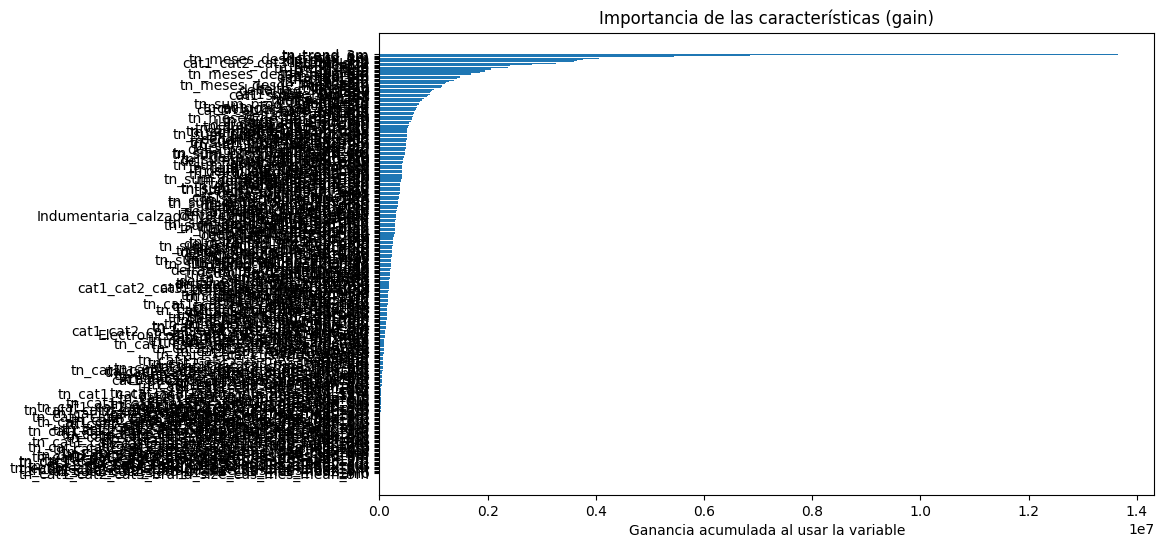

In [25]:
plt.figure(figsize=(10,6))
plt.barh(df_importances['feature'], df_importances['importance_gain'])
plt.xlabel('Ganancia acumulada al usar la variable')
plt.title('Importancia de las características (gain)')
plt.gca().invert_yaxis()
plt.show()

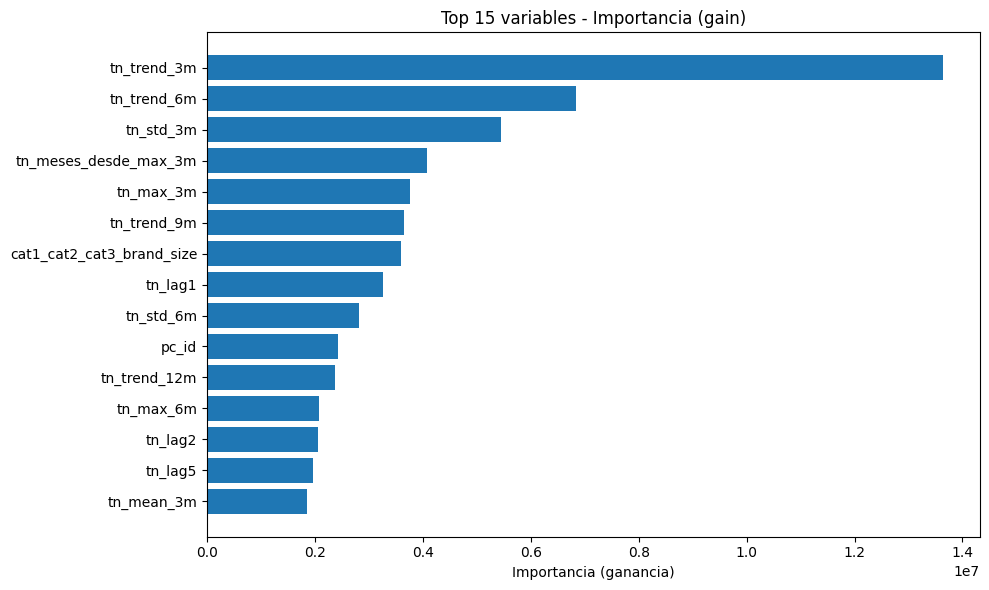

In [26]:
top = df_importances.sort_values('importance_gain', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top['feature'][::-1], top['importance_gain'][::-1])  # Invierte para mayor arriba
plt.xlabel('Importancia (ganancia)')
plt.title('Top 15 variables - Importancia (gain)')
plt.tight_layout()
plt.show()

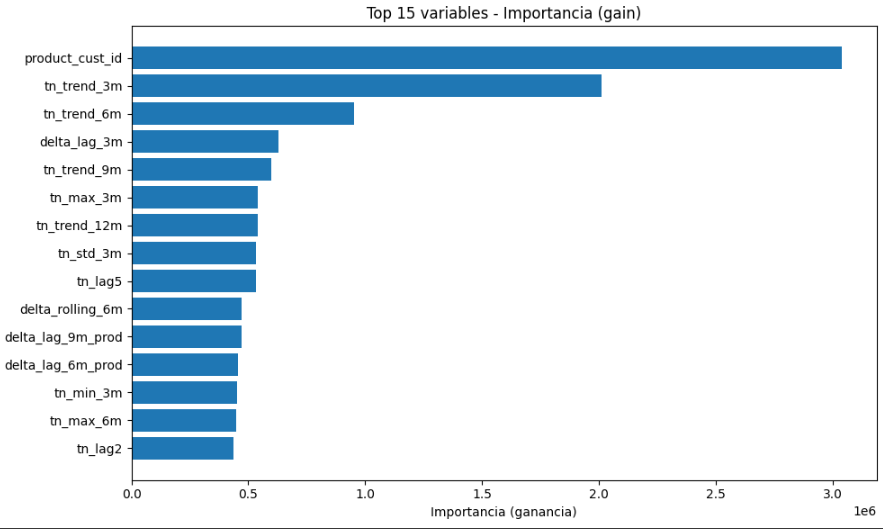

In [27]:
df_36 = df_cluster_X[df_cluster_X['date_mes'] == '2019-12'].copy()

# Escalar solo num_cols
for col in num_cols:
    tipo, val = scalers[col]
    if tipo == 'std':
        df_36[col] = df_36[col] / val
    elif tipo == 'mean':
        df_36[col] = df_36[col] / val
    # else: no escala

In [28]:
# Label encoding para categóricas (manejar categorías nuevas con cuidado)
for col in categorical_cols:
    le = le_dict[col]
    vals = df_36[col].astype(str).fillna('missing')
    # Si aparecen categorías nuevas, las convertimos a -1 para evitar error
    df_36[col] = vals.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

X_36 = df_36[num_cols + categorical_cols]

In [29]:
X_36.shape

(18169, 326)

In [30]:
# Predecimos la diferencia tn_38 - tn_36
pred_diff = gbm_final.predict(X_36)

# Reconstruimos la predicción absoluta para mes 38
df_36['tn_pred_38'] = df_36['tn'] + pred_diff

# Mostrar resultados
print(df_36[['product_cust_id', 'tn', 'tn_pred_38']].head())

      product_cust_id       tn  tn_pred_38
12756     20001_10001  180.219     204.796
47929     20001_10004   34.648      99.859
58407     20001_10005   19.604       9.931
68509     20001_10006   20.701      37.408
83569     20001_10008   48.057      46.548


/tmp/ipython-input-30-1009334013.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_36['tn_pred_38'] = df_36['tn'] + pred_diff


In [32]:
df_result = df_36[['product_cust_id', 'tn_pred_38']].copy()
df_result.head()

,product_cust_id,tn_pred_38
12756,20001_10001,204.796
47929,20001_10004,99.859
58407,20001_10005,9.931
68509,20001_10006,37.408
83569,20001_10008,46.548


In [33]:
df_historia.head()

,product_cust_id,min
0,20001_10001,13.297
1,20001_10004,34.648
2,20001_10005,0.862
3,20001_10006,3.551
4,20001_10008,11.090


In [34]:
# es muy raro que el mismo comprador compre menos de lo que ha comprado, y mucho menos puede comprar negativo
# Unimos ambos DataFrames usando product_cust_id como llave
df_result_1 = pd.merge(df_result, df_historia[['product_cust_id', 'min']], on='product_cust_id', how='inner')

# Definimos la función para calcular el forecast según las reglas dadas
def calcular_forecast(row):
    tn_pred = row['tn_pred_38']
    min_val = row['min']
    if tn_pred > min_val:
        return tn_pred
    elif tn_pred > (min_val / 2) and tn_pred <= min_val:
        return min_val
    else:
        return 0

# Aplicamos la función para calcular la nueva columna 'forecast'
df_result_1['forecast'] = df_result_1.apply(calcular_forecast, axis=1)

# Si solo quieres quedarte con product_cust_id y forecast:
df_result_1 = df_result_1[['product_cust_id', 'forecast']]

In [35]:
df_result_1.head()

,product_cust_id,forecast
0,20001_10001,204.796
1,20001_10004,99.859
2,20001_10005,9.931
3,20001_10006,37.408
4,20001_10008,46.548


In [36]:
# Crear nueva columna 'product_id' tomando los primeros 5 caracteres de 'product_cust_id'
df_result_1['product_id'] = df_result_1['product_cust_id'].str[:5]

# Agrupar por 'product_id' y sumarizar la columna 'forecast' en una nueva columna 'forecast_plus'
df_summary = df_result_1.groupby('product_id', as_index=False)['forecast'].sum()

# Renombrar la columna resultante para que se llame 'forecast_plus'
df_summary = df_summary.rename(columns={'forecast': 'forecast_plus'})

# Mostrar el resultado
print(df_summary.head())

  product_id  forecast_plus
0      20001        858.904
1      20002        368.635
2      20003        418.921
3      20004        460.372
4      20005        395.933


In [37]:
df_summary['product_id']=df_summary['product_id'].astype(int)

In [38]:
# Merge para obtener el promedio solo para los product_id que están en productos_validar
df_validar = productos_validar.merge(
    df_summary,
    on='product_id',
    how='left'
)

# Ahora df_validar_promedio tendrá dos columnas: product_id y tn_prom_2018
print(df_validar.head())

   product_id  forecast_plus
0       20001        858.904
1       20002        368.635
2       20003        418.921
3       20004        460.372
4       20005        395.933


In [39]:
# le cambio el nombre de mean a tn
df_validar.rename(columns={'forecast_plus': 'tn'}, inplace=True)
df_validar.head()

,product_id,tn
0,20001,858.904
1,20002,368.635
2,20003,418.921
3,20004,460.372
4,20005,395.933


In [40]:
df_validar.to_csv(DATOS_DIR +'df_cluster2_lgbm_V2.csv', index=False)